In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.amp import autocast, GradScaler

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

scaler_cbam_resnet_50 = GradScaler('cuda')

# 배치 크기
batch_size = 512 

transfrom = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 데이터셋 다운로드
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transfrom)
import torch
import torchvision
import torchvision.transforms as transforms

# 데이터 증강
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# 검증/테스트 데이터
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 데이터셋 다운로드
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Using device: cuda


In [2]:
from torch.utils.data import random_split

# Train/Validation 분할 (80:20)
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size

datasets = random_split(full_trainset, [train_size, val_size])
trainset = datasets[0]
valset = datasets[1]  

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()

        self.mlp = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
        )

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        b, c, _, _ = x.size()

        # average, max pooling
        avg_pool = self.avg_pool(x).view(b, c)
        max_pool = self.max_pool(x).view(b, c)

        # MLP, 동일 MLP 공유
        avg_out = self.mlp(avg_pool).view(b, c, 1, 1)
        max_out = self.mlp(max_pool).view(b, c, 1, 1)
        out = avg_out + max_out

        # scale
        scale = self.sigmoid(out).view(b, c, 1, 1)

        return x * scale

In [4]:
# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
         # 입력 채널 2(avg, max concat 결과) -> 출력 채널 1
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 채널 방향 평균/최대 풀링 -> [B, 1, H, W] 두 장
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)

        # concat -> [B, 2, H, W]
        pool_cat = torch.cat([avg_pool, max_pool], dim=1)

        # conv 7x7 -> sigmoid -> scale
        scale = self.sigmoid(self.conv(pool_cat))

        return x * scale  

In [5]:
class CBAM_Block(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM_Block, self).__init__()
        self.channel_attn = ChannelAttention(in_channels, reduction)
        self.spatial_attn = SpatialAttention(kernel_size)
        
    def forward(self, x):
        # channel attention 먼저 적용 후 spatial attention 적용
        x = self.channel_attn(x)
        x = self.spatial_attn(x)
        return x

In [6]:
import torch.nn.functional as F

class ResNetBottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, use_cbam=False, reduction=16):
        super(ResNetBottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        # CBAM Block 추가 여부
        if use_cbam:
            self.cbam = CBAM_Block(planes * self.expansion, reduction)
        else:
            self.cbam = nn.Identity() # CBAM Block 추가 안할 경우 그냥 통과

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = self.cbam(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [7]:
class Net(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, use_cbam=False, reduction=16):
        super(Net, self).__init__()
        self.in_planes = 64

        # 채널 수 3 -> 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # _make_layer 함수 호출하여 여러 개의 블록 그룹 생성
        self.layer1 = self._make_layer(block, 64, num_blocks[0], 1, use_cbam, reduction)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], 2, use_cbam, reduction)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], 2, use_cbam, reduction)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], 2, False, reduction) # 마지막 블록은 CBAM 추가 안함

        # average pooling 레이어 사용
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # 완전 연결 레이어(Fully Connected Layer) 512 * block.expansion -> 10개의 클래스로 분류
        self.fc = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, use_se=False, reduction=16):
        strides = [stride] + [1] * (num_blocks - 1) # 첫 번째 블록은 stride, 나머지는 1
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, use_se, reduction))
            self.in_planes = planes * block.expansion # 채널 수 증가
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [8]:
cbam_resnet_50 = Net(ResNetBottleneck, [3, 4, 6, 3], use_cbam=True, reduction=16)
cbam_resnet_50 = cbam_resnet_50.to(device)
cbam_resnet_50_loss = []
cbam_resnet_50_error = []

In [9]:
import torch.optim as optim
import numpy as np

# 크로스 엔트로피 손실 함수 사용
criterion = nn.CrossEntropyLoss()

# 모멘텀 0.9, weight_decay 1e-4
cbam_resnet_50_optimizer = optim.SGD(cbam_resnet_50.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# 학습률 스케줄링
cbam_resnet_50_scheduler = optim.lr_scheduler.ReduceLROnPlateau(cbam_resnet_50_optimizer, mode='min', factor=0.2, patience=5, min_lr=1e-6)

# 100번 에포크 학습
num_epochs = 100

In [10]:
# 평가 함수 (top1 error rate, top5 error rate)
def evaluate_model(model, data_loader, is_top5=False):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device) 
            labels = labels.to(device)  
            
            outputs = model(inputs)
            
            if is_top5:
                _, top5 = outputs.topk(5, dim=1)
                total_correct += (top5 == labels.unsqueeze(1)).any(dim=1).sum().item()
            else:
                _, predicted = torch.max(outputs.data, 1)
                total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    return (1 - total_correct / total_samples) * 100           

In [11]:
# CBAM-ResNet-50 model 학습 (스케줄링 적용)
for epoch in range(num_epochs):
    # 모델을 학습 모드로 설정
    cbam_resnet_50.train()
    
    running_loss_cbam_resnet_50 = 0.0
    
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print(f"Current LR - CBAM-ResNet50: {cbam_resnet_50_optimizer.param_groups[0]['lr']:.6f}")
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)  
        labels = labels.to(device)  

        # CBAM-ResNet-50 학습 (Mixed Precision)
        cbam_resnet_50_optimizer.zero_grad()

        # Mixed Precision 순전파
        with autocast(device_type='cuda', dtype=torch.float16):
            outputs_cbam_resnet_50 = cbam_resnet_50(inputs)
            loss_cbam_resnet_50 = criterion(outputs_cbam_resnet_50, labels)
        
        # Mixed Precision 역전파
        scaler_cbam_resnet_50.scale(loss_cbam_resnet_50).backward()
        scaler_cbam_resnet_50.step(cbam_resnet_50_optimizer)
        scaler_cbam_resnet_50.update()
    

        # 배치 손실 합계 계산
        running_loss_cbam_resnet_50 += loss_cbam_resnet_50.item()

        # 20 배치마다 검증 및 출력
        if (i + 1) % 20 == 0:
            val_error_cbam_resnet_50 = evaluate_model(cbam_resnet_50, val_loader)

            cbam_resnet_50_error.append(val_error_cbam_resnet_50)

            avg_loss_cbam_resnet_50 = running_loss_cbam_resnet_50 / 20
            
            cbam_resnet_50_loss.append(avg_loss_cbam_resnet_50)

            print(f"Batch {i + 1}: CBAM-ResNet50 Loss = {avg_loss_cbam_resnet_50:.4f}, Error = {val_error_cbam_resnet_50:.2f}%")
            
            # running_loss 초기화
            running_loss_cbam_resnet_50 = 0.0
    
    # 에포크 끝에서 스케줄러 업데이트 (검증 오류율 기준)
    if len(cbam_resnet_50_error) > 0:
        cbam_resnet_50_scheduler.step(cbam_resnet_50_error[-1])

print("학습 완료!")


Epoch 1/100
Current LR - CBAM-ResNet50: 0.001000
Batch 20: CBAM-ResNet50 Loss = 2.2659, Error = 90.10%
Batch 40: CBAM-ResNet50 Loss = 2.3042, Error = 85.11%
Batch 60: CBAM-ResNet50 Loss = 2.2463, Error = 82.36%

Epoch 2/100
Current LR - CBAM-ResNet50: 0.001000
Batch 20: CBAM-ResNet50 Loss = 2.0933, Error = 83.39%
Batch 40: CBAM-ResNet50 Loss = 2.0281, Error = 71.00%
Batch 60: CBAM-ResNet50 Loss = 1.8876, Error = 67.48%

Epoch 3/100
Current LR - CBAM-ResNet50: 0.001000
Batch 20: CBAM-ResNet50 Loss = 1.8547, Error = 68.77%
Batch 40: CBAM-ResNet50 Loss = 1.7835, Error = 63.61%
Batch 60: CBAM-ResNet50 Loss = 1.7370, Error = 63.09%

Epoch 4/100
Current LR - CBAM-ResNet50: 0.001000
Batch 20: CBAM-ResNet50 Loss = 1.6828, Error = 68.91%
Batch 40: CBAM-ResNet50 Loss = 1.7287, Error = 59.93%
Batch 60: CBAM-ResNet50 Loss = 1.5896, Error = 57.78%

Epoch 5/100
Current LR - CBAM-ResNet50: 0.001000
Batch 20: CBAM-ResNet50 Loss = 1.5617, Error = 62.82%
Batch 40: CBAM-ResNet50 Loss = 1.5684, Error = 5

In [12]:
# CBAM-ResNet-50 model 저장
torch.save(cbam_resnet_50.state_dict(), 'cbam_resnet_50.pth')

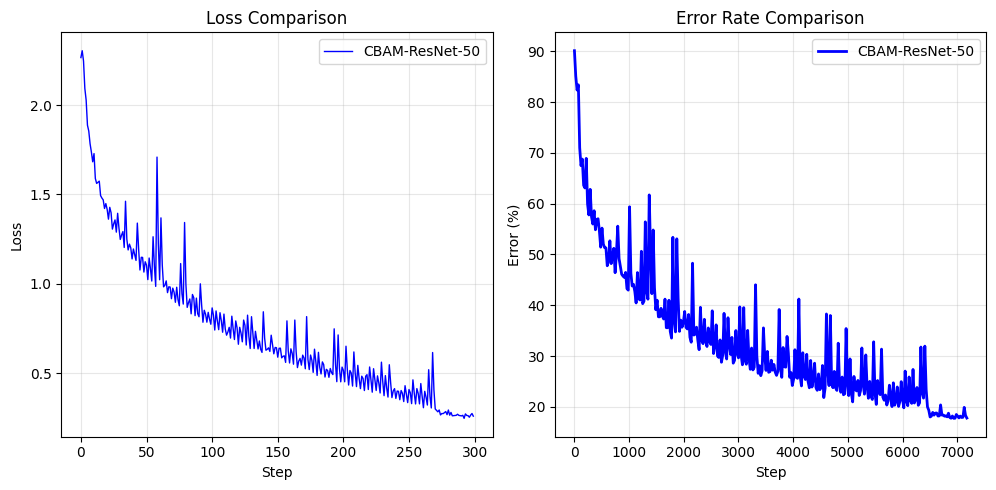

In [14]:
import matplotlib.pyplot as plt

# CBAM loss 그래프
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(cbam_resnet_50_loss, label='CBAM-ResNet-50', color='blue', linewidth=1)
plt.title("Loss Comparison")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# 오류율 step x 값 보정
x_values = [i * 24 for i in range(len(cbam_resnet_50_error))]

# 오류율 그래프
plt.subplot(1, 3, 2)
plt.plot(x_values, cbam_resnet_50_error, label='CBAM-ResNet-50', color='blue', linewidth=2)
plt.title("Error Rate Comparison")
plt.xlabel("Step")
plt.ylabel("Error (%)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# 최종 테스트 오류율 비교
cbam_resnet_50_test_top1_error = evaluate_model(cbam_resnet_50, test_loader)  

cbam_resnet_50_test_top5_error = evaluate_model(cbam_resnet_50, test_loader, is_top5=True)

print(f"CBAM-ResNet-50 Top1 Error: {cbam_resnet_50_test_top1_error:.2f}%, Top5 Error: {cbam_resnet_50_test_top5_error:.2f}%")

CBAM-ResNet-50 Top1 Error: 18.32%, Top5 Error: 0.79%
